In [1]:
import mdtraj as md
import bpmfwfft.grids as grids
import numpy as np

In [2]:
from os import walk
import socket
if socket.gethostname() == 'jim-Mint':
    ppi_path = '/media/jim/Research_TWO/FFT_PPI'
    home = '/home/jim'
else:
    ppi_path = '/home/jtufts/Desktop/FFT_PPI'
    home = '/home/jtufts'

In [3]:
f = {}
for (dirpath, dirnames, filenames) in walk(f'{ppi_path}/2.redock/2.minimize'):
    if filenames[0] != 'run_me.sh':
        if 'complex.pdb' in filenames:
            f[dirpath.split('/')[7]] = dirpath + '/complex.pdb'

In [4]:
import netCDF4 as nc
import numpy as np

grid_path = f'{ppi_path}/2.redock/4.receptor_grid/2OOB_A:B'
grid_nc = '%s/grid.nc'%grid_path


#parsing some of the netcdf variables from grid.nc
grid_variables = nc.Dataset(grid_nc, 'r').variables
counts = nc.Dataset(grid_nc, 'r').variables["counts"][:]
x = nc.Dataset(grid_nc, 'r').variables["x"][:]
y = nc.Dataset(grid_nc, 'r').variables["y"][:]
z = nc.Dataset(grid_nc, 'r').variables["z"][:]
electrostatic = nc.Dataset(grid_nc, 'r').variables["electrostatic"][:]
lja = nc.Dataset(grid_nc, 'r').variables["LJa"][:]
ljr = nc.Dataset(grid_nc, 'r').variables["LJr"][:]
sasai = nc.Dataset(grid_nc, 'r').variables["SASAi"][:]
sasar = nc.Dataset(grid_nc, 'r').variables["SASAr"][:]
trans_crd = nc.Dataset(grid_nc, 'r').variables["trans_crd"][:]
rec_disp = nc.Dataset(grid_nc, 'r').variables["displacement"][:]

In [5]:
from bpmfwfft.grids import RecGrid
from bpmfwfft.grids import LigGrid

rec_prmtop = f"{ppi_path}/2.redock/1.amber/2OOB_A:B/receptor.prmtop"
lj_sigma_scal_fact = 1.0
rec_inpcrd = f"{ppi_path}/2.redock/2.minimize/2OOB_A:B/receptor.inpcrd"

bsite_file = None
grid_nc_file = f"{ppi_path}/2.redock/4.receptor_grid/2OOB_A:B/grid.nc"

lig_prmtop = f"{ppi_path}/2.redock/1.amber/2OOB_A:B/ligand.prmtop"
# lig_inpcrd = f"{ppi_path}/2.redock/2.minimze/2OOB_A:B/ligand.inpcrd"

rot_nc = f"{ppi_path}/2.redock/3.ligand_rand_rot/2OOB_A:B/rotation.nc"
lig_rot = nc.Dataset(rot_nc, 'r').variables['positions']
lig_inpcrd = f"{ppi_path}/2.redock/2.minimize/2OOB_A:B/ligand.inpcrd"

rho = 9.0
rc_scale = 0.76
rs_scale = 0.53
rm_scale = 0.55
lc_scale = 0.81
ls_scale = 0.50
lm_scale = 0.54


def _create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, grid_nc_file):
    rec_grid = RecGrid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, 
                        grid_nc_file, new_calculation=False)
    return rec_grid

def _create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid):
    lig_grid = LigGrid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)
    return lig_grid

rec_grid = _create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, grid_nc_file)

lig_grid = _create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)

lig_grid._crd = np.array(lig_rot[0], dtype=np.float64)
lig_grid._move_ligand_to_lower_corner()

/home/jim/src/p39/fftanalysis
[1.]
/media/jim/Research_TWO/FFT_PPI/2.redock/4.receptor_grid/2OOB_A:B/grid.nc
[  0.     0.25   0.5    0.75   1.     1.25   1.5    1.75   2.     2.25
   2.5    2.75   3.     3.25   3.5    3.75   4.     4.25   4.5    4.75
   5.     5.25   5.5    5.75   6.     6.25   6.5    6.75   7.     7.25
   7.5    7.75   8.     8.25   8.5    8.75   9.     9.25   9.5    9.75
  10.    10.25  10.5   10.75  11.    11.25  11.5   11.75  12.    12.25
  12.5   12.75  13.    13.25  13.5   13.75  14.    14.25  14.5   14.75
  15.    15.25  15.5   15.75  16.    16.25  16.5   16.75  17.    17.25
  17.5   17.75  18.    18.25  18.5   18.75  19.    19.25  19.5   19.75
  20.    20.25  20.5   20.75  21.    21.25  21.5   21.75  22.    22.25
  22.5   22.75  23.    23.25  23.5   23.75  24.    24.25  24.5   24.75
  25.    25.25  25.5   25.75  26.    26.25  26.5   26.75  27.    27.25
  27.5   27.75  28.    28.25  28.5   28.75  29.    29.25  29.5   29.75
  30.    30.25  30.5   30.75  31.    31

In [46]:
names = ["SASA"]
lgrid = lig_grid.get_ligand_grids(names, [0,0,0])

In [47]:
import numpy as np
rgrid = np.add(sasar, sasai*1.j)

In [8]:
print((lgrid["SASA"]*rgrid).sum())

0j


In [9]:
lgrid_trans = grids.translate_grid(lgrid["SASA"], np.array([68,87,45]))

In [10]:
print((lgrid_trans*rgrid).sum())

(551+0j)


In [71]:
# fft test
lfft = np.fft.fftn(lgrid["SASA"].conjugate())
rfft = np.fft.fftn(rgrid)
cfft = np.fft.ifftn(rfft*lfft.conjugate())
score = np.real(cfft) - np.imag(cfft)*1000000

In [49]:
def rmsd(P: np.ndarray, Q: np.ndarray, **kwargs) -> float:
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        Root-mean-square deviation between the two vectors
    """
    diff = P - Q
    return np.sqrt((diff * diff).sum() / P.shape[0])

In [72]:
import copy
lig_grid._move_ligand_to_lower_corner()
lig_grid.translate_ligand(np.array([68,87,45])*lig_grid._spacing)
ref = copy.deepcopy(lig_grid._crd)
lig_grid._move_ligand_to_lower_corner()
lig_grid.translate_ligand(np.array([69,87,45])*lig_grid._spacing)
tar = copy.deepcopy(lig_grid._crd)

print("rmsd", rmsd(ref, tar))

Ligand translated by [-33.5 -44.  -24.5]
[1.14105129 1.36711311 1.38056588]
Ligand translated by [-34.  -43.5 -22.5]
[1.14105129 1.36711311 1.38056588]
rmsd 0.5


In [73]:
print(np.amax(score))
k = 200  # number of scores to save
flat_score = score.flatten()
flat_argp = np.argpartition(flat_score, -k)[-k:]

1386.0000002326615


In [74]:
top_scores = flat_score[flat_argp]
top_scores.sort()
translations = []
trans_scores = []

for score_val in top_scores:
    t = np.where(score == score_val)
    a = np.array(t)
    if a.shape == (3,2):
        for x,y,z in a.transpose():
            x = np.array([x])
            y = np.array([y])
            z = np.array([z])
            translations.append((x,y,z))
            trans_scores.append(score[x,y,z])
            # print((x,y,z),  score[x,y,z], cfft[x,y,z])
    else:
        translations.append(t)
        trans_scores.append(score[t])
        # print(t, score[t], cfft[t])

In [ ]:
def cat_grids(grid1, grid2):
    prmtop = cat_dictionaries(grid1._prmtop,grid2._prmtop)
    crd = cat_dictionaries(grid1._crd,grid2._crd)
    cat_grid = copy.deepcopy(grid1)
    cat_grid._prmtop = prmtop
    cat_grid._crd = crd
    return cat_grid

def cat_dictionaries(dict1, dict2):
    dict1_copy = copy.deepcopy(dict1)
    dict2_copy = copy.deepcopy(dict2)
    
    if isinstance(dict1_copy, dict):
        keys = list(dict1_copy.keys())
        for key in keys:
            # print(keys)
            # print(key)
            dict1_copy[key] = cat_values(dict1[key], dict2[key])
        return dict1_copy
    
    elif isinstance(dict1_copy, np.ndarray):
        return np.concatenate((dict1_copy,dict2_copy))

def cat_values(a1, a2):
    array1 = copy.deepcopy(a1)
    array2 = copy.deepcopy(a2)
    if isinstance(array1, np.ndarray):
        return np.concatenate((array1,array2))
    elif isinstance(array1, dict):
        return cat_dictionaries(array1, array2)
    elif isinstance(array1, (int, np.int64)):
        # print(f"{array1+array2}")
        return array1 + array2
    elif isinstance(array1, list):
        # print(type(array1))
        # print(f'array1:{len(array1)}, array2:{len(array2)}')
        array1.extend(array2)
        # print(f'complex:{len(array1)}, sum:{len(a1)+len(a2)}')
        return array1

        
        
import copy
# result = map(cat_dictionaries, rec_grid._prmtop, lig_grid._prmtop)
delta_sasas = []
colors = []
for v,vector in enumerate(translations):
    vector = (np.array(vector).transpose()*lig_grid._spacing)[0]
    lig_grid._move_ligand_to_lower_corner()
    print(vector)
    lig_grid.translate_ligand(vector)
    com_grid = cat_grids(rec_grid, lig_grid)
    c_sasa = com_grid._get_molecule_sasa(0.14, 960).sum()
    l_sasa = lig_grid._get_molecule_sasa(0.14, 960).sum()
    r_sasa = rec_grid._get_molecule_sasa(0.14, 960).sum()
    d_sasa = (l_sasa + r_sasa) - c_sasa
    delta_sasas.append(d_sasa)
    rmsd_to_native = rmsd(ref, lig_grid._crd)
    if rmsd_to_native < 5.:
        # colors.append([255, 0, 0])
        colors.append("red")
    else:
        # colors.append([0, 255, 255])
        colors.append("black")
        
    print(c_sasa, l_sasa + r_sasa, d_sasa)
    com_grid.write_pdb(f'{home}/Desktop/translations/com/trans{v}.pdb', "w")
    lig_grid.write_pdb(f'{home}/Desktop/translations/lig/trans{v}.pdb', "w")
    rec_grid.write_pdb(f'{home}/Desktop/translations/lig/rec.pdb', "w")


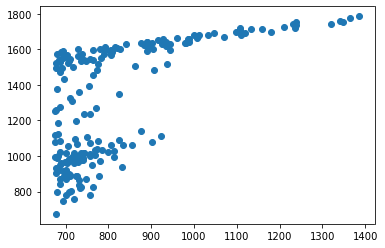

In [76]:
import matplotlib.pyplot as plt
plt.scatter(trans_scores, delta_sasas)
plt.show()

In [ ]:
for u in range(len(translations)):
    print(score[translations[u]], delta_sasas[u])

In [12]:
com_grid.write_pdb('/home/jtufts/Desktop/test.pdb', "w")
com_grid.write_box('/home/jtufts/Desktop/testbox.pdb')

NATOM:2008


In [134]:
# print(cat_dictionaries(rec_grid._prmtop['POINTERS'], lig_grid._prmtop['POINTERS']))
print(com_grid._get_molecule_sasa(0.14, 960).sum())
print(lig_grid._get_molecule_sasa(0.14, 960).sum())
print(rec_grid._get_molecule_sasa(0.14, 960).sum())
print(rec_grid._get_molecule_sasa(0.14, 960).sum()+lig_grid._get_molecule_sasa(0.14, 960).sum())

7170.8086
3486.3755
4483.7715
7970.147


In [119]:
print(lig_grid._molecule_sasa.sum())

5823.7266


In [140]:
import pickle as p
f1 = np.load('/home/jtufts/Desktop/npy/delta_sasa_complex_minus_rl.npy')
f2 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/lig_sasa_sums.p', "rb"))
f3 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/rec_sasa_sums.p', "rb"))
f4 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/lig_sasas.p', "rb"))
f5 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/rec_sasas.p', "rb"))
f6 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/complex_sasas.p', "rb"))
# f4

In [138]:
k2 = list(f2.keys())
k2.sort()
print(k2[127],f2[k2[127]]*100+f3[k2[127]]*100)

2OOB_A:B 7970.235824584961


In [ ]:
lig_grid._move_ligand_to_lower_corner()
ls = lig_grid._get_molecule_sasa(0.14, 960)
rs = rec_grid._get_molecule_sasa(0.14, 960)

for m,val in enumerate(f4[k2[127]][0]):
    print(val,ls[0][m])

In [ ]:
for p,l in enumerate(delta_sasas):
    print(l, f1[127]*100)

In [165]:
(rec_disp - lig_grid._displacement)/0.5

masked_array(data=[68.0, 87.0, 45.0],
             mask=[False, False, False],
       fill_value=1e+20)

In [160]:
rec_disp

masked_array(data=[40.5, 56. , 27. ],
             mask=False,
       fill_value=1e+20)

In [166]:
score[68,87,45]

591.9999999999999

In [167]:
cfft[68,87,45]

(592.0000000000001+2.326614353372607e-13j)

In [81]:
def regplot(trans_scores, delta_sasas, colors, name):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import linregress
    from sklearn.linear_model import LinearRegression

    x = np.array(trans_scores)
    y = np.array(delta_sasas)
    C = np.array(colors, dtype=str)

    change = np.where(C == 'yellow')
    C[change] = "black"

    indicies = np.where(y < 1525)
    # indicies = np.where(y == 0)

    indicies = indicies[::-1]

    for i in indicies:
        x = np.delete(x, i)
        y = np.delete(y, i)
        C = np.delete(C, i)

    indicies = np.where(x == 0)
    indicies = indicies[::-1] 

    for i in indicies:
        x = np.delete(x, i)
        y = np.delete(y, i)
        C = np.delete(C, i)

    x = x.reshape((-1,1))

    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)

    print('coefficient of determination:', r_sq)
    print('intercept:', model.intercept_)
    print('slope:', model.coef_)


    # scatter plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, 10, c=C, alpha=0.5, marker='+',
            label="SC SCORE vs Delta SASA")
    # regression plot
    rx = np.linspace(x.min(), x.max(), 165)
    ry = model.coef_*rx + model.intercept_

    ax.plot(rx, ry, '-r', label=f'DELTA_SASA={float(model.coef_):.4f}*SC_SCORE + {float(model.intercept_):.2f}')
    plt.xlabel("SC_score")
    plt.ylabel("Delta_SASA (nm^2)")
    ax.set_title(f'R2: {r_sq}')
    ax.legend(loc='upper left')
    plt.savefig(f'{name}')

In [ ]:
for i in range(9):
    # rx,ry,rz = np.random.randint(0, counts[0], 3)
    # rx = np.random.randint(19, 39, 1)
    # ry = np.random.randint(81, 101, 1)
    # rz = np.random.randint(74, 94, 1)
    rx = np.random.randint(26, 32, 1)
    ry = np.random.randint(113, 119, 1)
    rz = np.random.randint(49, 55, 1)
    lgrid_trans = grids.translate_grid(lgrid["SASA"], [rx,ry,rz])
    result = (lgrid_trans*rgrid).sum()
    print((rx,ry,rz), result, cfft[rx,ry,rz], (np.real(result)-np.imag(result)), score[rx,ry,rz])

In [ ]:
for i in range(len(colors)):
    print(i, colors[i])

In [ ]:
rec_grid._prmtop